<a href="https://colab.research.google.com/github/yeboipk/2048-ai-project/blob/main/2048_dqn_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 1/1000 [00:00<05:02,  3.31it/s]

Episode 0 | Score: 323.9751944301165 | Epsilon: 0.995


100%|██████████| 1000/1000 [02:45<00:00,  6.05it/s]


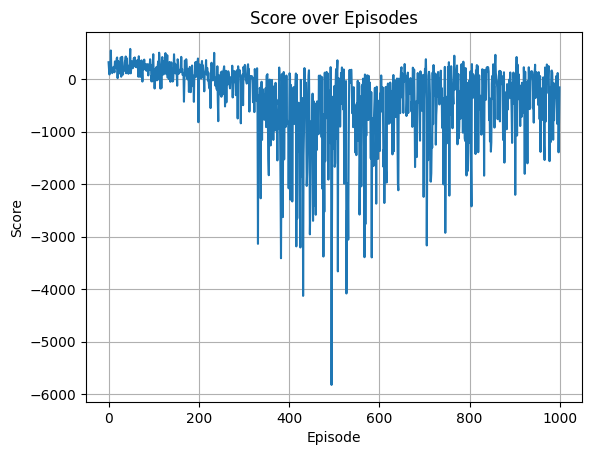

In [ ]:
# 2048 AI using Deep Q-Learning (PyTorch)
!pip install -q tqdm

import numpy as np
import random
from collections import deque
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- 2048 Game Environment ---
class Game2048:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((4, 4), dtype=int)
        self.score = 0
        self.done = False
        self.add_tile()
        self.add_tile()
        return self.get_observation()

    def get_observation(self):
        return self.board.copy()

    def add_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if empty:
            i, j = random. choice(empty)
            self.board[i][j] = 2 if random.random() < 0.9 else 4

    def compress(self, row):
        new_row = [i for i in row if i != 0]
        new_row += [0] * (4 - len(new_row))
        return new_row

    def merge(self, row):
        new_row = []
        skip = False
        for i in range(4):
            if skip:
                skip = False
                continue
            if i < 3 and row[i] == row[i+1] and row[i] != 0:
                new_row.append(row[i]*2)
                self.score += row[i]*2
                skip = True
            else:
                new_row.append(row[i])
        new_row += [0] * (4 - len(new_row))
        return new_row

    def move(self, direction):
        prev_score = self.score
        original = self.board.copy()
        moved = False
        new_board = self.board.copy()
        for i in range(4):
            if direction == 0:
                col = new_board[:, i]
                col = self.compress(col)
                col = self.merge(col)
                new_board[:, i] = col
            elif direction == 1:
                col = new_board[:, i][::-1]
                col = self.compress(col)
                col = self.merge(col)
                new_board[:, i] = col[::-1]
            elif direction == 2:
                row = new_board[i]
                row = self.compress(row)
                row = self.merge(row)
                new_board[i] = row
            elif direction == 3:
                row = new_board[i][::-1]
                row = self.compress(row)
                row = self.merge(row)
                new_board[i] = row[::-1]

        if not np.array_equal(self.board, new_board):
            self.board = new_board
            self.add_tile()
            moved = True

        if not self.can_move():
            self.done = True

        merged_score = self.score - prev_score
        num_empty = np.sum(self.board == 0)
        reward = (merged_score ** 0.7 + 0.1 * num_empty) if moved else -10
        return self.get_observation(), reward, self.done

    def can_move(self):
        if np.any(self.board == 0):
            return True
        for i in range(4):
            for j in range(3):
                if self.board[i][j] == self.board[i][j+1] or self.board[j][i] == self.board[j+1][i]:
                    return True
        return False

# --- Deep Q-Network ---
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.log2(x + 1) / 16
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- DQN Agent ---
class DQNAgent:
    def __init__(self):
        self.model = DQN()
        self.target = DQN()
        self.target.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.memory = deque(maxlen=5000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        with torch.no_grad():
            q_values = self.model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
        return q_values.argmax().item()

    def remember(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.stack(states), dtype=torch.float32)
        actions = torch.tensor(actions).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.model(states).gather(1, actions)
        with torch.no_grad():
            q_next = self.target(next_states).max(1)[0].unsqueeze(1)
            q_target = rewards + (1 - dones) * self.gamma * q_next

        loss = F.mse_loss(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target.load_state_dict(self.model.state_dict())

# --- Training Loop ---
env = Game2048()
agent = DQNAgent()

EPISODES = 1000
scores = []

for episode in tqdm(range(EPISODES)):
    state = env.reset()
    total_reward = 0
    step = 0
    while not env.done:
        action = agent.act(state)
        next_state, reward, done = env.move(action)
        agent.remember(state, action, reward, next_state, done)
        if step % 4 == 0:
            agent.train()
        state = next_state
        total_reward += reward
        step += 1

    scores.append(total_reward)
    agent.update_target()
    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

    if episode % 2000 == 0:
        print(f"Episode {episode} | Score: {total_reward} | Epsilon: {agent.epsilon:.3f}")
        torch.save(agent.model.state_dict(), f"2048_dqn_checkpoint_{episode}.pth")

# --- Final Save ---
torch.save(agent.model.state_dict(), "2048_dqn_model.pth")

# --- Score Plot ---
plt.plot(scores)
plt.title("Score over Episodes")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [ ]:
!pip install gradio
import gradio as gr
import numpy as np
import torch
import torch.nn.functional as F
from dataclasses import dataclass, field
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import io
import time
import threading

# --- Game2048 Logic ---
@dataclass
class Game2048:
    board: np.ndarray = field(default_factory=lambda: np.zeros((4, 4), dtype=int))
    score: int = 0
    done: bool = False

    def reset(self):
        self.board = np.zeros((4, 4), dtype=int)
        self.score = 0
        self.done = False
        self.add_tile()
        self.add_tile()
        return self.board

    def add_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if empty:
            i, j = empty[np.random.randint(len(empty))]
            self.board[i][j] = 2 if np.random.rand() < 0.9 else 4

    def compress(self, row):
        new_row = [i for i in row if i != 0]
        new_row += [0] * (4 - len(new_row))
        return new_row

    def merge(self, row):
        new_row = []
        skip = False
        for i in range(4):
            if skip:
                skip = False
                continue
            if i < 3 and row[i] == row[i+1] and row[i] != 0:
                new_row.append(row[i]*2)
                self.score += row[i]*2
                skip = True
            else:
                new_row.append(row[i])
        new_row += [0] * (4 - len(new_row))
        return new_row

    def move(self, direction):
        moved = False
        new_board = self.board.copy()
        for i in range(4):
            if direction == 0:  # Up
                col = new_board[:, i]
                col = self.compress(col)
                col = self.merge(col)
                new_board[:, i] = col
            elif direction == 1:  # Down
                col = new_board[:, i][::-1]
                col = self.compress(col)
                col = self.merge(col)
                new_board[:, i] = col[::-1]
            elif direction == 2:  # Left
                row = new_board[i]
                row = self.compress(row)
                row = self.merge(row)
                new_board[i] = row
            elif direction == 3:  # Right
                row = new_board[i][::-1]
                row = self.compress(row)
                row = self.merge(row)
                new_board[i] = row[::-1]

        if not np.array_equal(self.board, new_board):
            self.board = new_board
            self.add_tile()
            moved = True

        if not self.can_move():
            self.done = True

        return moved

    def can_move(self):
        if np.any(self.board == 0):
            return True
        for i in range(4):
            for j in range(3):
                if self.board[i][j] == self.board[i][j+1] or self.board[j][i] == self.board[j+1][i]:
                    return True
        return False

# --- DQN Model ---
import torch.nn as nn
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.log2(x + 1) / 16
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- Load Trained Model ---
model = DQN()
model.load_state_dict(torch.load("2048_dqn_model.pth", map_location=torch.device("cpu")))
model.eval()

game = Game2048()
game.reset()

# --- Tile Colors ---
tile_colors = {
    0: (205, 193, 180),
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46)
}

# --- Load Font Safely ---
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
if not Path(font_path).exists():
    import os
    os.system("apt-get install -y fonts-dejavu")
font = ImageFont.truetype(font_path, size=36)

# --- Render Board as Image ---
def render_board_image(board):
    size = 100
    border_width = 4
    img = Image.new("RGB", (size*4, size*4), (187, 173, 160))
    draw = ImageDraw.Draw(img)
    for i in range(4):
        for j in range(4):
            value = board[i][j]
            color = tile_colors.get(value, (60, 58, 50))
            x0, y0 = j*size, i*size
            x1, y1 = (j+1)*size, (i+1)*size
            draw.rectangle([x0, y0, x1, y1], fill=color, outline=(119, 110, 101), width=border_width)
            if value != 0:
                text = str(value)
                bbox = font.getbbox(text)
                w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
                draw.text((x0 + (size - w)//2, y0 + (size - h)//2), text, fill=(0,0,0), font=font)
    return img

# --- AI Move ---
def play_ai_move():
    if game.done:
        return render_board_image(game.board), f"Score: {game.score} | Game Over!"
    with torch.no_grad():
        x = torch.tensor(game.board, dtype=torch.float32).unsqueeze(0)
        q_values = model(x).squeeze().numpy()
        sorted_actions = np.argsort(q_values)[::-1]  # Descending
        moved = False
        for action in sorted_actions:
            if game.move(action):
                moved = True
                break
        if not moved:
            for fallback_action in range(4):
                if game.move(fallback_action):
                    moved = True
                    break
        if not moved:
            game.done = True
            return render_board_image(game.board), f"Stuck! Final Score: {game.score}"
    status = f"Score: {game.score}"
    if game.done:
        status += " | Game Over!"
    return render_board_image(game.board), status

# --- Reset Game ---
def reset_game():
    game.reset()
    return render_board_image(game.board), f"Score: {game.score}"

# --- Manual Move ---
def manual_move(direction):
    moved = game.move(direction)
    status = f"Score: {game.score}"
    if game.done:
        status += " | Game Over!"
    return render_board_image(game.board), status

# --- Gradio Interface ---
with gr.Blocks() as demo:
    gr.Markdown("## 2048 AI Player")
    gr.Markdown("Click 'AI Move' to let the AI make a move. Click 'Reset' to restart.")

    autoplay_flag = gr.State(value=False)

    image = gr.Image(type="pil", label="Board")
    status = gr.Textbox(label="Status")

    with gr.Row():
        move_btn = gr.Button("AI Move")
        reset_btn = gr.Button("Reset")
        autoplay_btn = gr.Button("Toggle Autoplay")

    with gr.Row():
        left_btn = gr.Button("⬅️")
        up_btn = gr.Button("⬆️")
        right_btn = gr.Button("➡️")
        down_btn = gr.Button("⬇️")

    move_btn.click(play_ai_move, outputs=[image, status])
    reset_btn.click(reset_game, outputs=[image, status]).then(lambda: False, None, autoplay_flag)

    left_btn.click(lambda: manual_move(2), outputs=[image, status])
    up_btn.click(lambda: manual_move(0), outputs=[image, status])
    right_btn.click(lambda: manual_move(3), outputs=[image, status])
    down_btn.click(lambda: manual_move(1), outputs=[image, status])

    def autoplay_loop():
        while autoplay_flag.value and not game.done:
            img, msg = play_ai_move()
            image.update(value=img)
            status.update(value=msg)
            time.sleep(0.5)

    def toggle_autoplay(current):
        autoplay_flag.value = not current
        if autoplay_flag.value:
            threading.Thread(target=autoplay_loop, daemon=True).start()
        return autoplay_flag.value

    autoplay_btn.click(toggle_autoplay, inputs=autoplay_flag, outputs=autoplay_flag)

    demo.load(fn=reset_game, outputs=[image, status])



demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1dc1f62d9cd062aece.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
